# Polymers and membranes
ref: [link](https://userguide.mdanalysis.org/stable/examples/analysis/polymers_and_membranes/README.html).  

MDAnalysis has several analyses specifically for polymers, membranes, and membrane proteins.

In [1]:
import warnings 

import MDAnalysis as mda

from MDAnalysis.tests.datafiles import TRZ_psf, TRZ
from MDAnalysis.analysis import polymer

%matplotlib inline
warnings.filterwarnings("ignore")

## Deteremining the persistence length of a polymer
Here we determine the persistence length of a polymer.

In [2]:
# loading files 
u = mda.Universe(TRZ_psf, TRZ)

In [3]:
# Choosing the chains and backbone atoms
chains = u.atoms.fragments
backbones = [ch.select_atoms('not name O* H*') for ch in chains]

This should give us AtomGroups where the spatial arrangement is linear. However, the atoms are in index order. We can use sort_backbone to arrange our atom groups into their linear arrangement order.

In [4]:
sorted_bb = [polymer.sort_backbone(bb) for bb in backbones]

In [5]:
# Calculating the persistence length
plen = polymer.PersistenceLength(sorted_bb)
plen.run()

The average bond length is found at `plen.results.lb`, the calculated persistence length at `plen.results.lp`, the measured autocorrelation at `plen.results` and the modelled decorrelation fit at `plen.results.fit`.

In [6]:
print(plen.results.fit.shape)
print('The persistence length is {:.3f}'.format(plen.results.lp))

(179,)
The persistence length is 6.917


<Axes: xlabel='x', ylabel='$C(x)$'>

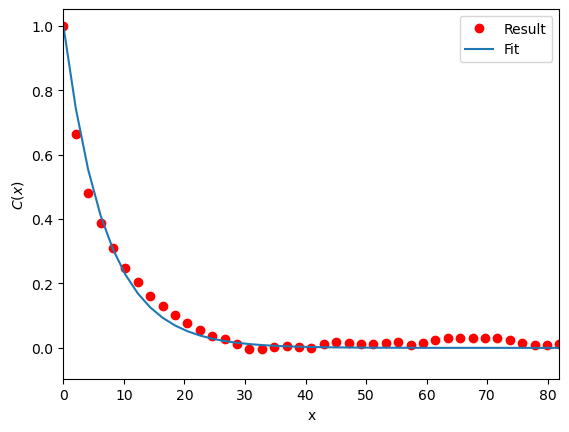

In [7]:
plen.plot()

## Analysing pore dimensions with HOLE2
Here we use HOLE to analyse pore dimensions in a membrane.

The `MDAnalysis.analysis.hole2 `module provides wrapper classes and functions that call the `HOLE` program. This means you must have installed the program yourself before you can use the class. You then have 2 options, you either pass the path to your hole executable to the class; in this example, hole is installed at `~/hole2/exe/hole`. Or, set your binary path variable ($PATH in Unix systems) to point to the executable’s folder so you don’t have to point to the binary explicitly every time you call hole or any of its helper tools. This is what we have done here, so we don’t have to set the executable argument.

HOLE defines a series of points throughout the pore from which a sphere can be generated that does not overlap any atom (as defined by its van der Waals radius). By default, it ignores residues with the following names: “SOL”, “WAT”, “TIP”, “HOH”, “K “, “NA “, “CL “. You can change these with the ignore_residues keyword. Note that the residue names must have 3 characters. Wildcards do not work.

This tutorial first demonstrates how to use the `MDAnalysis.analysis.hole2.hole` function similarly to the HOLE binary on a PDB file. We then demonstrate how to use the `MDAnalysis.analysis.hole2.HoleAnalysis` class on a trajectory of data. You may prefer to use the more fully-featured HoleAnalysis class for the extra functionality we provide, such as creating an animation in VMD of the pore.

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from MDAnalysis.tests.datafiles import PDB_HOLE
from MDAnalysis.analysis import hole2

### using HOLE with a PDB file
The hole function allows you to specify points to begin searching at (`cpoint`) and a search direction (`cvect`), the sampling resolution (`sample`), and more. Please see the documentation for full details.

The PDB file here is the experimental structure of the Gramicidin A channel. Note that we pass `HOLE` a PDB file directly, without creating a `MDAnalysis.Universe`.

We are setting a `random_seed` here so that the results in the tutorial can be reproducible. This is normally not advised.

In [9]:
# using HOLE with a PDB file
profiles = hole2.hole(PDB_HOLE,
                      outfile='hole1.out',
                      sphpdb_file='hole1.sph',
                      vdwradii_file=None,
                      random_seed=31415,
                      executable='~/hole2/exe/hole',
                    #   keep_files=False
                      )

# If you do not want to keep the files, set keep_files=False. 
# Keep in mind that you will not be able to create a VMD surface without the sphpdb file.

This will create several outputs in your directory:

* hole1.out: the log file for HOLE.

* hole1.sph: a PDB-like file containing the coordinates of the pore centers.

* simple2.rad: file of Van der Waals’ radii

* tmp/pdb_name.pdb: the short name of a PDB file with your structure. As hole is a FORTRAN77 program, it is limited in how long of a filename that it can read. Symlinking the file to the current directory can shorten the path.



In [10]:
profiles[0].shape

(425,)

Each profile is a `numpy.recarray` with the fields below as an entry for each `rxncoord`:

* rxn_coord: the distance along the pore axis in angstrom

* radius: the pore radius in angstrom

* cen_line_D: distance measured along the pore centre line - the first point found is set to zero.

In [11]:
profiles[0].dtype.names

('rxn_coord', 'radius', 'cen_line_D')

In [12]:
rxn_coords = profiles[0].rxn_coord
pore_length = rxn_coords[-1] - rxn_coords[0]
print('The pore is {} angstroms long'.format(pore_length))

The pore is 42.4 angstroms long


In [13]:
hole2.create_vmd_surface(filename='hole1.vmd',
                         sphpdb='hole1.sph',
                         sph_process='~/hole2/exe/sph_process',
                         )

'hole1.vmd'

To view this, open your PDB file in VMD.

`vmd tmp*/*.pdb`

Load the output file in Extensions > Tk Console:

`source hole1.vmd`

Your pore surface will be drawn as below.

### Using HOLE with a trajectory
One of the limitations of the `hole` program is that it can only accept PDB files. In order to use other formats with `hole`, or to run `hole` on trajectories, we can use the `hole2.HoleAnalysis` class with an `MDAnalysis.Universe`. While the example file below is a PDB, you can use any files to create your Universe. You can also specify that the HOLE analysis is only run on a particular group of atoms with the `select` keyword (default value: ‘protein’).

As with `hole()`, `HoleAnalysis` allows you to select a starting point for the search (`cpoint`). You can pass in a coordinate array; alternatively, you can use the center-of-geometry of your atom selection in each frame as the start.

In [14]:
from MDAnalysis.tests.datafiles import MULTIPDB_HOLE

u = mda.Universe(MULTIPDB_HOLE)

ha = hole2.HoleAnalysis(u, select='protein',
                        cpoint='center_of_geometry',
                        executable='~/hole2/exe/hole',
                        )
ha.run(random_seed=31415)

Again, the data is stored in `ha.results.profiles` as a dictionary of `numpy.recarrays`. The dictionary is indexed by frame; we can see the HOLE profile for the fourth frame below (truncated to the first 10 values).

In [15]:
# working wiht the data
for rxn_coord, radius, cen_line_D in (ha.results.profiles[3][:10]):
    print(f"{rxn_coord:.2f}, {radius:.2f}, {cen_line_D:.2f}")

-21.01, 15.35, -39.24
-20.91, 12.63, -34.65
-20.81, 10.64, -30.05
-20.71, 9.58, -27.73
-20.61, 8.87, -25.40
-20.51, 8.57, -23.62
-20.41, 8.56, -21.84
-20.31, 8.48, -21.74
-20.21, 8.39, -21.64
-20.11, 8.30, -21.54


If you want to collect each individual property, use `gather()`. Setting `flat=True` flattens the lists of `rxn_coord`, `radius`, and `cen_line_D`, in order. You can select which frames you want by passing an iterable of frame indices to `frames`. `frames=None` returns all frames.

In [16]:
gathered = ha.gather()
print(gathered.keys())

dict_keys(['rxn_coord', 'radius', 'cen_line_D'])


In [17]:
print(len(gathered['rxn_coord']))

11


In [18]:
flat = ha.gather(flat=True)
print(len(flat['rxn_coord']))

3967


You may also want to collect the radii in bins of `rxn_coord` for the entire trajectory with the `bin_radii()` function. `range` should be a tuple of the lower and upper edges of the first and last bins, respectively. If `range=None`, the minimum and maximum values of `rxn_coord` are used.

`bins` can be either an iterable of (lower, upper) edges (in which case `range` is ignored), or a number specifying how many bins to create with `range`.

In [19]:
radii, edges = ha.bin_radii(bins=100, range=None)

In [20]:
means, edges = ha.histogram_radii(bins=100, range=None,
                                  aggregator=np.mean)

Text(0.5, 0, 'Pore coordinate $\\zeta$ ($\\AA$)')

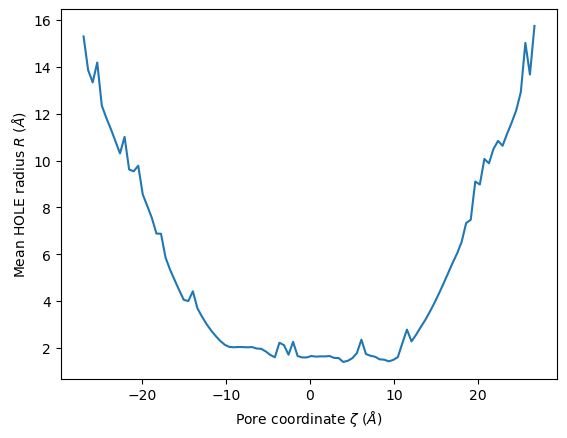

In [21]:
midpoints = 0.5*(edges[1:]+edges[:-1])
plt.plot(midpoints, means)
plt.ylabel(r"Mean HOLE radius $R$ ($\AA$)")
plt.xlabel(r"Pore coordinate $\zeta$ ($\AA$)")

`HoleAnalysis` also has the `min_radius()` function, which will return the minimum radius in angstrom for each frame. The resulting array has the shape (#n_frames, 2).

In [22]:
min_radii = ha.min_radius()
for frame, min_radius in min_radii:
    print(f"Frame {int(frame)}: {min_radius:.3f}")

Frame 0: -0.237
Frame 1: 1.567
Frame 2: 1.533
Frame 3: 1.425
Frame 4: 1.243
Frame 5: 1.198
Frame 6: 1.296
Frame 7: 1.438
Frame 8: 1.511
Frame 9: 0.879
Frame 10: 0.997


Text(0.5, 0, 'Frame')

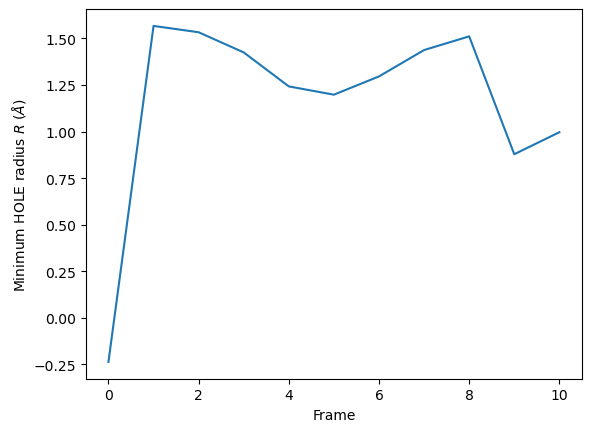

In [23]:
plt.plot(min_radii[:, 0], min_radii[:, 1])
plt.ylabel('Minimum HOLE radius $R$ ($\AA$)')
plt.xlabel('Frame')

<Axes: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

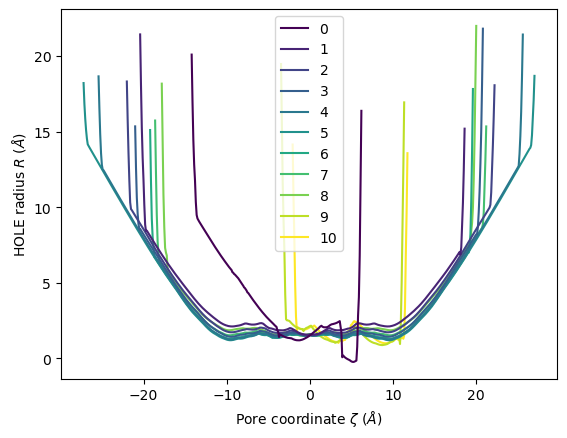

In [24]:
# plotting
ha.plot()

<Axes: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

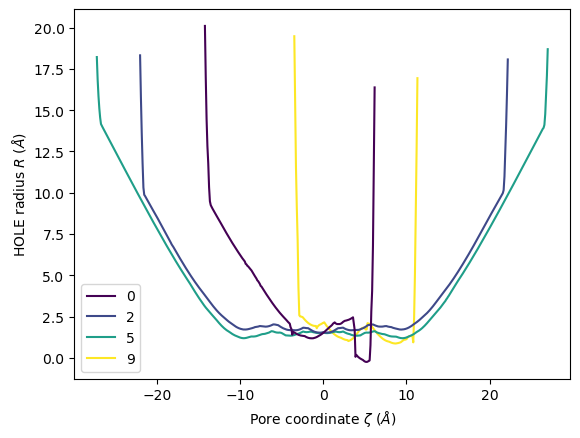

In [25]:
ha.plot(frames=[0, 2, 5, 9]) # specify frames

<Axes3D: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='Frames', zlabel='HOLE radius $R$ ($\\AA$)'>

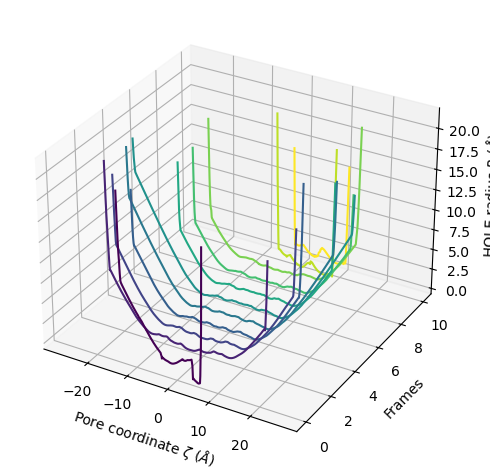

In [26]:
ha.plot3D()

<Axes3D: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='Frames', zlabel='HOLE radius $R$ ($\\AA$)'>

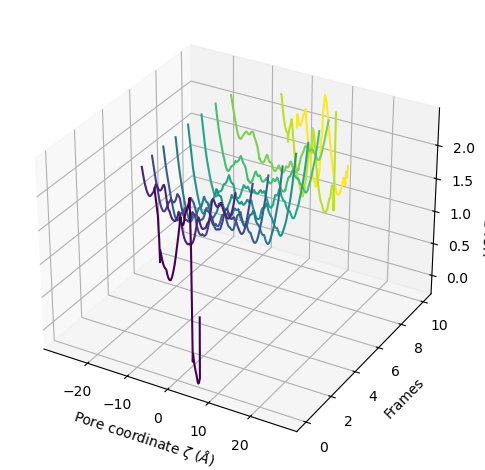

In [27]:
ha.plot3D(r_max=2.5)

<Axes: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='HOLE radius $R$ ($\\AA$)'>

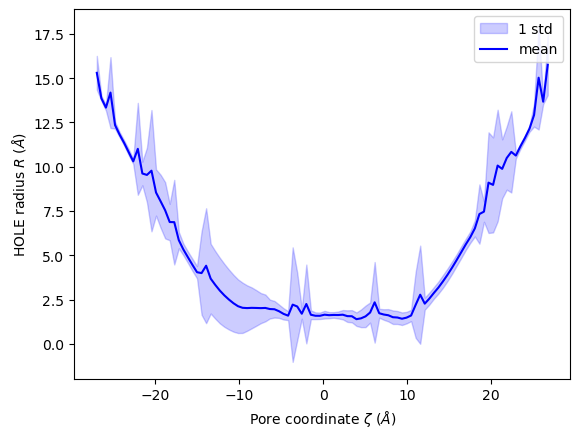

In [28]:
ha.plot_mean_profile(bins=100,  # how much to chunk rxn_coord
                     n_std=1,  # how many standard deviations from mean
                     color='blue',  # color of plot
                     fill_alpha=0.2,  # opacity of standard deviation
                     legend=True)

### Visualising the VMD surface
The create_vmd_surface() method is built into the HoleAnalysis class. It writes a VMD file that changes the pore surface for each frame in VMD. Again, load your file and source the file in the Tk Console:

`source holeanalysis.vmd`

In [29]:
ha.create_vmd_surface(filename='holeanalysis.vmd')

'holeanalysis.vmd'

### Ordering HOLE profiles with an order parameter
If you are interested in the HOLE profiles over an order parameter, you can directly pass that into the analysis after it is run. Below, we use an order parameter of RMSD from a reference structure.

In [30]:
from MDAnalysis.analysis import rms

ref = mda.Universe(PDB_HOLE)
rmsd = rms.RMSD(u, ref, select='protein', weights='mass').run()
rmsd_values = rmsd.rmsd[:, 2]
for i, rmsd in enumerate(rmsd_values):
    print(f"Frame {i}:  {rmsd:.2f}")

Frame 0:  6.11
Frame 1:  4.88
Frame 2:  3.66
Frame 3:  2.44
Frame 4:  1.22
Frame 5:  0.00
Frame 6:  1.22
Frame 7:  2.44
Frame 8:  3.66
Frame 9:  4.88
Frame 10:  6.11


You can pass this in as `order_parameter`. The resulting `profiles` dictionary will have your order parameters as keys. You should be careful with this if your order parameter has repeated values, as duplicate keys are not possible; each duplicate key just overwrites the previous value.

In [31]:
op_profiles = ha.over_order_parameters(rmsd_values)

In [32]:
for order_parameter, profile in op_profiles.items():
    print(f"{order_parameter:.3f}, {len(profile)}")

0.000, 543
1.221, 389
1.221, 511
2.442, 419
2.442, 399
3.663, 379
3.663, 443
4.884, 391
4.884, 149
6.105, 205
6.105, 139


In [33]:
op_profiles = ha.over_order_parameters(rmsd_values, frames=[0, 4, 9])
for order_parameter, profile in op_profiles.items():
    print(f"{order_parameter:.3f}, {len(profile)}")

1.221, 511
4.884, 149
6.105, 205


<Axes: xlabel='RMSD to reference ($\\AA$)', ylabel='Minimum HOLE pore radius $r$ ($\\AA$)'>

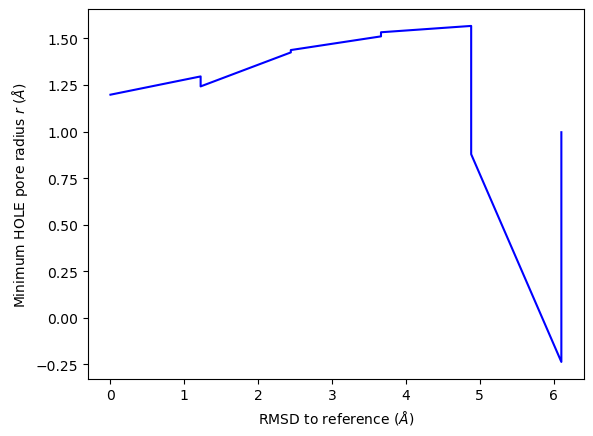

In [34]:
# plotting
ha.plot_order_parameters(rmsd_values,
                         aggregator=min,
                         xlabel='RMSD to reference ($\AA$)',
                         ylabel='Minimum HOLE pore radius $r$ ($\AA$)')

<Axes3D: xlabel='Pore coordinate $\\zeta$ ($\\AA$)', ylabel='RMSD to reference ($\\AA$)', zlabel='HOLE radius $R$ ($\\AA$)'>

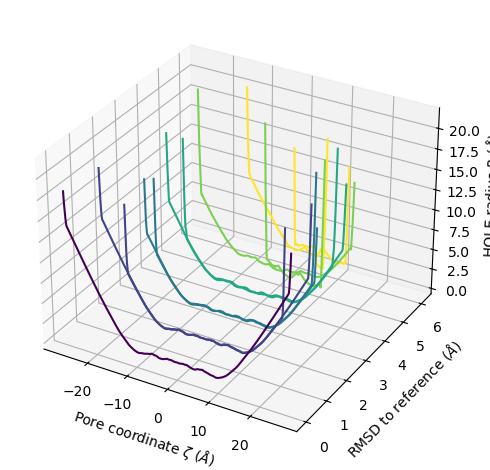

In [35]:
ha.plot3D_order_parameters(rmsd_values,
                           ylabel='RMSD to reference ($\AA$)')

### Deleting HOLE files
The HOLE program and related MDAnalysis code write a number of files out. Both the `hole()` function and `HoleAnalysis` class contain ways to easily remove these files.

For `hole()`, pass in `keep_files=False` to delete HOLE files as soon as the analysis is done. However, this will also remove the sphpdb file required to create a VMD surface from the analysis. If you need to write a VMD surface file, use the `HoleAnalysis` class instead.

You can track the created files at the `tmp_files` attribute.

In [36]:
ha.tmp_files

['simple2.rad',
 'hole000.out',
 'hole000.sph',
 'hole001.out',
 'hole001.sph',
 'hole002.out',
 'hole002.sph',
 'hole003.out',
 'hole003.sph',
 'hole004.out',
 'hole004.sph',
 'hole005.out',
 'hole005.sph',
 'hole006.out',
 'hole006.sph',
 'hole007.out',
 'hole007.sph',
 'hole008.out',
 'hole008.sph',
 'hole009.out',
 'hole009.sph',
 'hole010.out',
 'hole010.sph']

In [37]:
# delete temporary files
ha.delete_temporary_files()
ha.tmp_files

[]

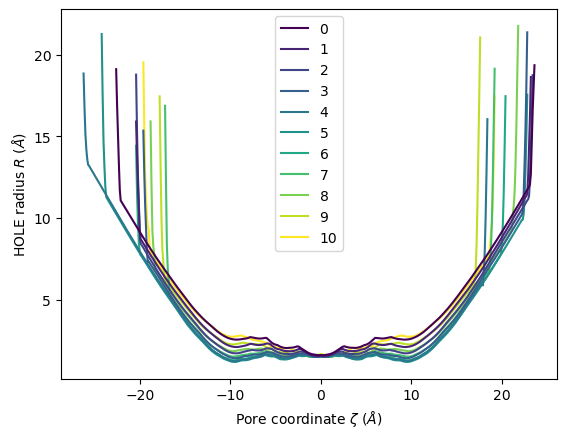

In [38]:
with hole2.HoleAnalysis(u,
    executable='~/hole2/exe/hole',
    ) as ha2:
    ha2.run()
    ha2.create_vmd_surface(filename='holeanalysis.vmd')
    ha2.plot()

In [39]:
ha.profiles[0][0].radius

20.0962